In [119]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [120]:
data = pd.read_csv('Cleaned_data.csv').set_index('Unnamed: 0')
data.index = np.arange(len(data))

In [121]:
state_columns = ['Env1', 'Env2', 'Env3', 'Env4', 'Env5', 'Env6', 'Env7', '현재값']
action_column = ['Agent']

In [122]:
state = data[state_columns]
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(state)
state = scaler.transform(state)
state = state[:-1]

In [123]:
action = data[action_column].iloc[:-1]
next_state = data[state_columns].loc[1:]

In [124]:
stack_size = 20

In [125]:
stacked_state = []
for i in range(len(state) - stack_size):
    current_state =  state[i : i + stack_size]
    stacked_state.append(current_state)

In [126]:
state_np = np.array(stacked_state)

In [127]:
x_0 = state_np.copy()
x_1 = action.iloc[stack_size - 1 : -1].values
y = next_state.iloc[stack_size -1 : -1].values

In [128]:
train_x_0 = x_0[:-1000]
train_x_1 = x_1[:-1000]
train_y = y[:-1000]

test_x_0 = x_0[-1000:]
test_x_1 = x_1[-1000:]
test_y = y[-1000:]

In [129]:
def create_lstm_model():
    state_input = tf.keras.layers.Input(shape = (stack_size, 8))
    action_input = tf.keras.layers.Input(shape = (action.shape[1],))
    action_layer = tf.keras.layers.Dense(units = 4, activation = 'relu')(action_input)
    rnn_layer = tf.keras.layers.LSTM(16)(state_input)
    concat_layer = tf.keras.layers.Concatenate()([action_layer, rnn_layer])
    layer = tf.keras.layers.Dense(units = 64, kernel_initializer = 'he_normal')(concat_layer)
    # layer = tf.keras.layers.BatchNormalization()(layer)
    layer = tf.keras.layers.Activation('relu')(layer)
    layer = tf.keras.layers.Dense(units = 64, activation = 'relu', kernel_initializer = 'he_normal')(layer)
    output = tf.keras.layers.Dense(units = 8)(layer)
    return tf.keras.Model(inputs = [state_input, action_input], outputs = output)

In [130]:
lstm_model = create_lstm_model()

In [131]:
initial_learning_rate = 0.1
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=2,
    decay_rate=0.96,
    staircase=True)

In [132]:
lstm_model.compile(loss = 'mse', optimizer = tf.keras.optimizers.Adam(), metrics = ['accuracy'])

In [133]:
lstm_model.fit(x= [train_x_0, train_x_1], y = train_y, validation_split = 0.1, batch_size = 32, epochs = 20)

Epoch 1/20
11393/11393 [==============================] - 42s 4ms/step - loss: 2.5306 - accuracy: 0.9939 - val_loss: 0.0843 - val_accuracy: 1.0000
Epoch 2/20
11393/11393 [==============================] - 42s 4ms/step - loss: 0.0463 - accuracy: 0.9995 - val_loss: 0.0304 - val_accuracy: 1.0000
Epoch 3/20
11393/11393 [==============================] - 42s 4ms/step - loss: 0.0361 - accuracy: 0.9996 - val_loss: 0.0494 - val_accuracy: 1.0000
Epoch 4/20
11393/11393 [==============================] - 43s 4ms/step - loss: 0.0312 - accuracy: 0.9996 - val_loss: 0.0192 - val_accuracy: 1.0000
Epoch 5/20
11393/11393 [==============================] - 42s 4ms/step - loss: 0.0292 - accuracy: 0.9996 - val_loss: 0.0189 - val_accuracy: 1.0000
Epoch 6/20
11393/11393 [==============================] - 42s 4ms/step - loss: 0.0280 - accuracy: 0.9997 - val_loss: 0.0198 - val_accuracy: 1.0000
Epoch 7/20
11393/11393 [==============================] - 42s 4ms/step - loss: 0.0273 - accuracy: 0.9997 - val_loss: 0

In [134]:
output = lstm_model.predict([test_x_0, test_x_1])
splited_ouput  =np.split(output, 8, axis = 1)

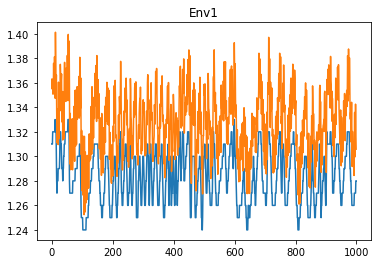

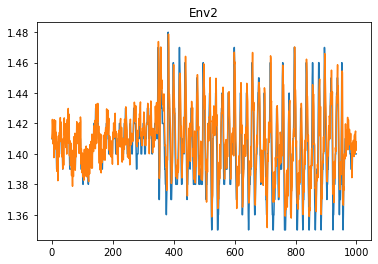

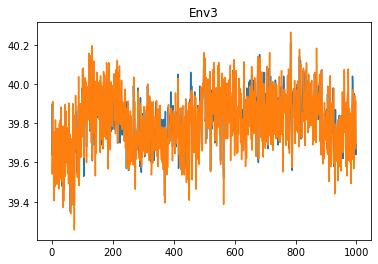

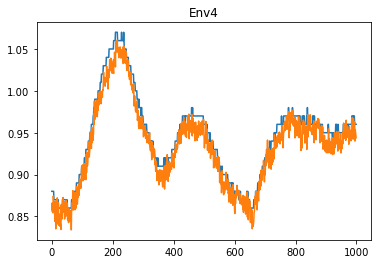

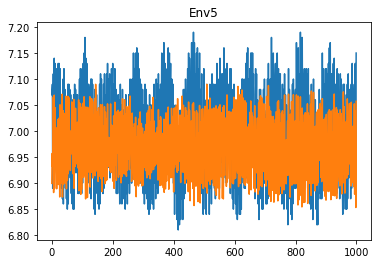

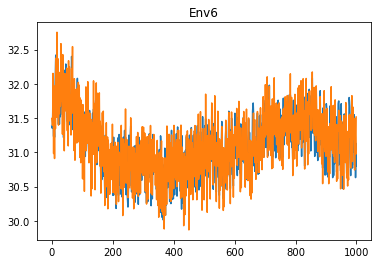

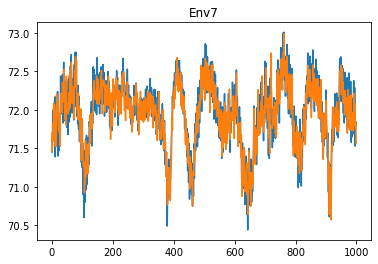

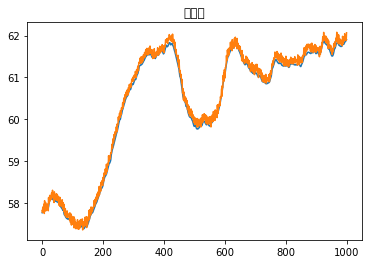

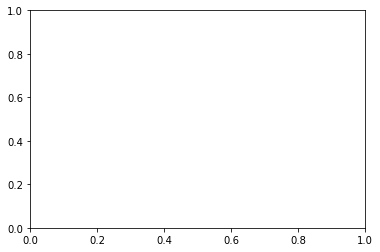

In [135]:
for i in range(8):
    plt.plot(test_y[:, i])
    plt.plot(splited_ouput[i])
    plt.title(state_columns[i])
    plt.show()
    plt.cla()

In [136]:
lstm_model.summary()

Model: "functional_29"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_34 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_33 (InputLayer)           [(None, 20, 8)]      0                                            
__________________________________________________________________________________________________
dense_65 (Dense)                (None, 4)            8           input_34[0][0]                   
__________________________________________________________________________________________________
lstm_16 (LSTM)                  (None, 16)           1600        input_33[0][0]                   
______________________________________________________________________________________